In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from tqdm.notebook import tqdm
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

import jaxley as jx
from jaxley.connect import connect

from jaxley_mech.synapses.ribbon_mGluR6 import Ribbon_mGluR6, META
from jaxley_mech.channels.kamiyama09 import Leak, Kv, Ca, CaNernstReversal, KCa, ClCa, Hyper, CaPump
from jaxley_mech.channels.chen24 import Phototransduction

In [2]:
META

{'species': ['larval zebrafish', 'rat'],
 'cell_type': ['UV cone photoreceptor', 'rod bipolar cell'],
 'reference': ['Schroeder, C., Oesterle, J., Berens, P., Yoshimatsu, T., & Baden, T. (2021). eLife.',
  'Nishiyama, S., Hosoki, Y., Koike, C., & Amano, A. (2014). IEEE, 6116-6119.'],
 'doi': 'https://doi.org/10.7554/eLife.67851'}

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.
KGlu: 5.0 vesicles


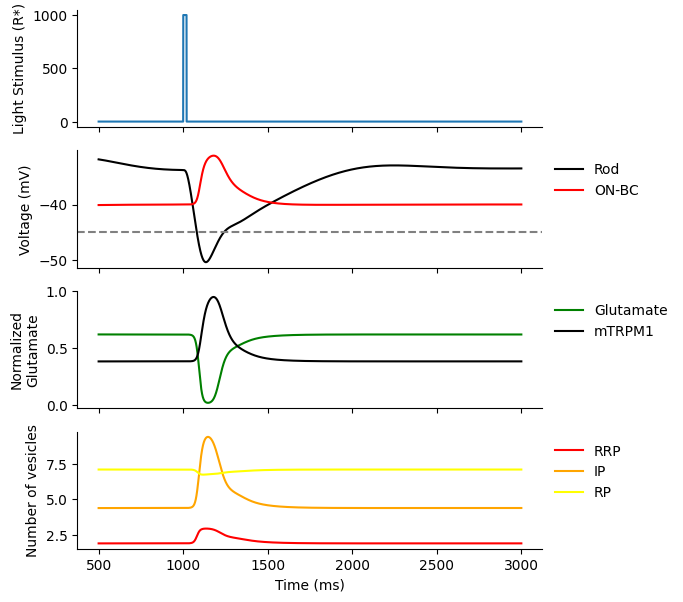

In [3]:
n_cells = 2
dt = 0.025
_ = np.random.seed(0)

# Define a compartment, branch, and cell
comp = jx.Compartment()
branch = jx.Branch(comp, ncomp=1)
cell = jx.Cell(branch, parents=[-1])

# Define the network and connectivity
network = jx.Network([cell for _ in range(n_cells)])
connect(
    network.cell(0).branch(0).comp(0), network.cell(1).branch(0).comp(0), Ribbon_mGluR6(solver="newton")
)

# Insert rod mechanisms
network.cell(0).insert(Kv())
network.cell(0).insert(Hyper(solver='newton'))
network.cell(0).insert(Ca())
network.cell(0).insert(ClCa())
network.cell(0).insert(KCa())
network.cell(0).insert(CaPump(solver='newton'))
network.cell(0).insert(CaNernstReversal())
network.cell(0).insert(Leak())
network.cell(0).insert(Phototransduction(solver='newton'))
prefix = "Phototransduction"
params_mouse_rod = {
    f"{prefix}_sigma": 7.66, # /s, opsin decay rate constant
    f"{prefix}_phi": 7.66, # /s, PDE decay rate constant
    f"{prefix}_eta": 1.62, # /s, PDE dark activate rate
    f"{prefix}_gamma": 8, # unitless, Opsin gain
    f"{prefix}_beta": 25, # /s, Ca2+ extrusion rate constant
    f"{prefix}_k": 0.01, # pA / μM, cGMP-to-current constant
    f"{prefix}_m": 4, # unitless, Cooperativity of GC Ca2+ dependence
    f"{prefix}_n": 3, # unitless, cGMP cahnnel cooperativity
    f"{prefix}_K_GC": 0.4, # μM, Affinity of GC Ca2+ dependence
    f"{prefix}_G_dark": 13.4, # μM, cGMP concentration in dark
    f"{prefix}_C_dark": 1, # μM, Ca2+ concentration in dark    
}
for name, param in params_mouse_rod.items():
    network.cell(0).set(name, param)
# Insert ON-BC mechanisms (Ishihara et al. 1998)
network.cell(1).insert(Kv())
network.cell(1).insert(Hyper(solver='newton'))
network.cell(1).insert(KCa())
network.cell(1).insert(Ca())
network.cell(1).insert(Leak())

network.init_states()

# Set voltages to resting membrane potential
network.cell([0, 1]).set("v", -40)

# Adjust the synapse
Vhalf = -45.0
network.Ribbon_mGluR6.set("Ribbon_mGluR6_gTRPM1", 1.65 * 10**-3)
network.Ribbon_mGluR6.set("Ribbon_mGluR6_V_half", Vhalf)
network.Ribbon_mGluR6.set("Ribbon_mGluR6_k", 0.5)
network.Ribbon_mGluR6.set("Ribbon_mGluR6_e_max", 1.0)
network.Ribbon_mGluR6.set("Ribbon_mGluR6_r_max", 4.0)

network.delete_recordings()
# Record voltage
network.cell(0).record(verbose=True)
network.cell(1).record(verbose=True)
# Record glutamate
network.cell([0,1]).record("Ribbon_mGluR6_exo", verbose=True)
network.cell([0,1]).record("Ribbon_mGluR6_mTRPM1", verbose=True)
network.cell([0,1]).record("Ribbon_mGluR6_RRP", verbose=True)
network.cell([0,1]).record("Ribbon_mGluR6_IP", verbose=True)
network.cell([0,1]).record("Ribbon_mGluR6_RP", verbose=True)

# Design stimulus
background_intensity = 0
intensity = 1000
pre_light_time = 1000  # ms
light_on_time = 20  # ms
total_time = pre_light_time + 2000 # ms
dt = 0.025 # ms
time_steps = int(total_time // dt + 1)
Jhv = jnp.zeros(time_steps) + background_intensity
light_on_start = int(pre_light_time / dt)
light_on_end = int((pre_light_time + light_on_time) / dt)
Jhv = Jhv.at[light_on_start:light_on_end].set(background_intensity + intensity)

# Clamp the phototransduction current
network.cell(0).clamp("Phototransduction_Stim", Jhv)

v = jx.integrate(network, t_max=total_time, delta_t=dt, solver="bwd_euler")

fig, ax = plt.subplots(4, 1, figsize=(6, 7), sharex=True)
colors = ["k", "r"]
cells = ["Rod", "ON-BC"]
ramp_up = 500 # ms
time = jnp.arange(ramp_up, total_time, dt)

_ = ax[0].plot(time, Jhv[int(ramp_up/dt):])
for i in range(2):
    ax[1].plot(time, v[i, int(ramp_up/dt):-1], color=colors[i], label=cells[i])
ax[1].axhline(Vhalf, color="gray", linestyle="--")

colors = ["g", "k"]
labels = ["Glutamate", "mTRPM1"]
# Normalize the glutamate
KGlu = network.Ribbon_mGluR6.edges["Ribbon_mGluR6_KGlu"].values[0]
print(f"KGlu: {KGlu} vesicles")
ufunc = lambda v: v**2 / (v**2 + KGlu**2)
v = v.at[2, :].apply(ufunc)
for  i in range(2, 4):
    ax[2].plot(time, v[i, int(ramp_up/dt):-1], color=colors[i-2], label=labels[i-2])

colors = ["r", "orange", "yellow"]
labels = ["RRP", "IP", "RP"]
for i in range(4, 7):
    ax[3].plot(time, v[i, int(ramp_up/dt):-1], color=colors[i-4], label=labels[i-4])

ax[0].set_ylabel("Light Stimulus (R*)")

ax[1].set_ylabel("Voltage (mV)")
ax[1].legend(frameon=False, bbox_to_anchor=(1.0, 1.0))

ax[2].set_ylabel("Normalized\nGlutamate")
ax[2].legend(frameon=False, bbox_to_anchor=(1.0, 1.0))
ax[2].set_yticks([0, 0.5, 1.0])

ax[3].legend(frameon=False, bbox_to_anchor=(1.0, 1.0))
ax[3].set_ylabel("Number of vesicles")
ax[3].set_xlabel("Time (ms)")

sns.despine();

  0%|          | 0/3 [00:00<?, ?it/s]

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.


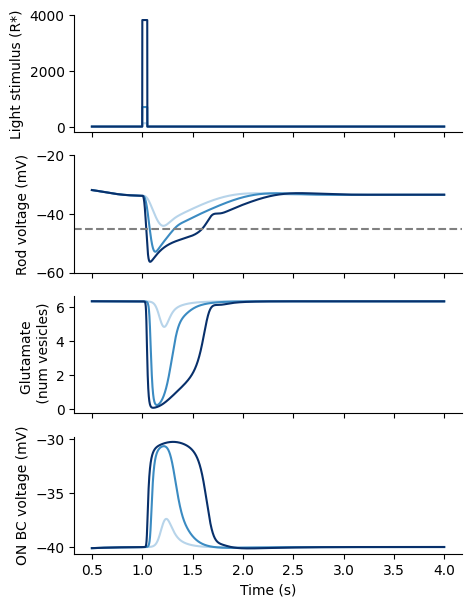

In [4]:
fig, ax = plt.subplots(4, 1, figsize=(5, 7), sharex=True)
ramp_up = 500 # ms

# Vary the light intensity
factor = 2e2
intensities = [0.6*factor, 3.5*factor, 19.1*factor]
colors = plt.cm.Blues(np.linspace(0.3, 1, len(intensities)))

for n, i in enumerate(tqdm(intensities)):
    # Design stimulus
    background_intensity = 0
    intensity = i
    pre_light_time = 1000  # ms
    light_on_time = 50  # ms
    total_time = pre_light_time + 3000 # ms
    dt = 0.025 # ms
    time_steps = int(total_time // dt + 1)
    Jhv = jnp.zeros(time_steps) + background_intensity
    light_on_start = int(pre_light_time / dt)
    light_on_end = int((pre_light_time + light_on_time) / dt)
    Jhv = Jhv.at[light_on_start:light_on_end].set(background_intensity + intensity)
    time = jnp.arange(ramp_up, total_time, dt) / 1000

    # Clamp the phototransduction current
    network.delete_clamps("Phototransduction_Stim")
    network.cell(0).clamp("Phototransduction_Stim", Jhv)

    v = jx.integrate(network, t_max=total_time, delta_t=dt, solver="bwd_euler")

    # Stimulus
    ax[0].plot(time, Jhv[int(ramp_up/dt):], color=colors[n])

    # Presynaptic voltage
    ax[1].plot(time, v[0, int(ramp_up/dt):-1], color=colors[n])

    # Plot the glutamate
    ax[2].plot(time, v[2, int(ramp_up/dt):-1], color=colors[n])

    # Postsynaptic voltage
    ax[3].plot(time, v[1, int(ramp_up/dt):-1], color=colors[n])


# Formatting
ax[1].axhline(Vhalf, color="gray", linestyle="--")
ax[1].set_yticks(np.arange(-60, 0, step=20))

ax[0].set_ylabel("Light stimulus (R*)")
ax[1].set_ylabel("Rod voltage (mV)")
ax[2].set_ylabel("Glutamate \n (num vesicles)")
ax[3].set_ylabel("ON BC voltage (mV)")
ax[3].set_xlabel("Time (s)")

sns.despine();

  0%|          | 0/3 [00:00<?, ?it/s]

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.


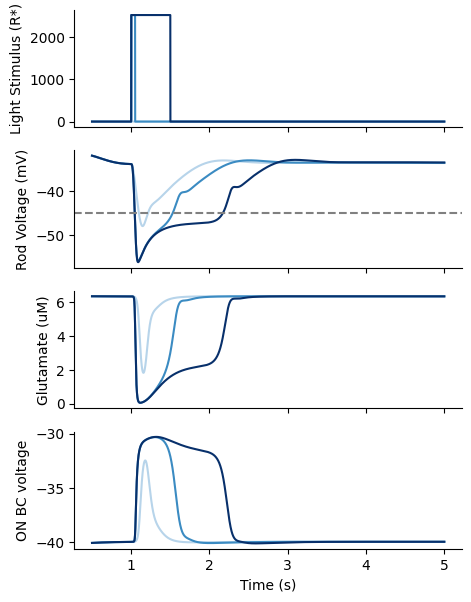

In [5]:
fig, ax = plt.subplots(4, 1, figsize=(5, 7), sharex=True)
colors = ["k", "r"]
cells = ["Cone", "ON-BC"]
ramp_up = 500 # ms

# Vary the light duration
durations = [5, 50, 500]
colors = plt.cm.Blues(np.linspace(0.3, 1, len(durations)))

for n, d in enumerate(tqdm(durations)):
    # Design stimulus
    background_intensity = 0
    intensity = 12.6 * factor
    pre_light_time = 1000  # ms
    light_on_time = d  # ms
    total_time = pre_light_time + 4000 # ms
    dt = 0.025 # ms
    time_steps = int(total_time // dt + 1)
    Jhv = jnp.zeros(time_steps) + background_intensity
    light_on_start = int(pre_light_time / dt)
    light_on_end = int((pre_light_time + light_on_time) / dt)
    Jhv = Jhv.at[light_on_start:light_on_end].set(background_intensity + intensity)
    time = jnp.arange(ramp_up, total_time, dt) / 1000

    # Clamp the phototransduction current
    network.delete_clamps("Phototransduction_Stim")
    network.cell(0).clamp("Phototransduction_Stim", Jhv)

    v = jx.integrate(network, t_max=total_time, delta_t=dt, solver="bwd_euler")

    # Stimulus
    ax[0].plot(time, Jhv[int(ramp_up/dt):], color=colors[n])

    # Presynaptic voltage
    ax[1].plot(time, v[0, int(ramp_up/dt):-1], color=colors[n])

    # Plot the glutamate
    ax[2].plot(time, v[2, int(ramp_up/dt):-1], color=colors[n])

    # Postsynaptic voltage
    ax[3].plot(time, v[1, int(ramp_up/dt):-1], color=colors[n])

# Formatting
ax[1].axhline(Vhalf, color="gray", linestyle="--")
ax[0].set_ylabel("Light Stimulus (R*)")
ax[1].set_ylabel("Rod Voltage (mV)")
ax[2].set_ylabel("Glutamate (uM)")
ax[3].set_ylabel("ON BC voltage")
ax[3].set_xlabel("Time (s)")

sns.despine();

### Notes
- Things change quite a bit when using cone photoreceptors, and intensities need to be cranked up a lot

In [6]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-02-21 09:31:19CET

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.32.0

jax        : 0.4.31
jaxley_mech: 0.3.0
matplotlib : 3.10.0
seaborn    : 0.13.2
jaxley     : 0.6.2
tqdm       : 4.67.1
numpy      : 2.2.3

Watermark: 2.5.0

